## Spike haplotypes

Generated using cliqueSNV on the BWA alignments w/ a required freq of >= 10%.

Outputs were renamed to include sample name (see haplotype code) and input into NextClade 3.4.0. Wuhan-1 and the AY119 were also added.

- Adjusted using adjust_haplotype_names.py
- Uploaded into nextclade 3.7.4

Spike alignments/translations were downloaded and used here to determine aa differences. 

In [1]:
suppressMessages({
library('ggplot2')
library('tidyverse')
library('dplyr')
library('glue')
library('stringr')
library('stringi')
library("Biostrings")
})

In [2]:
wkdir = '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources'
setwd(wkdir)
source(glue("{wkdir}/scripts/haplotype_extra.R"))

In [3]:
message("Generate figure directories")
FIG_DIR = glue("{wkdir}/figures/")  # set up figure directory for outputs
if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }
message('figures will be saved in: ', FIG_DIR)

Generate figure directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources/figures/



In [5]:
# input files: 
fasta = glue("{wkdir}/data/pb10.nextclade.cds_translation.S.fasta")
summary_meta = read.csv(glue('{wkdir}/data/summary_data.csv'))  # summary data of virus abundance
meta = read.csv(glue('{wkdir}/data/autopsy_meta.v3.csv'))  

REF_DIR = glue("{wkdir}/data/autopsy_refs/")
aa_refs = Sys.glob(glue("{REF_DIR}/*aadf*"), dirmark = FALSE)
voc_df = read.csv(glue("{wkdir}/data/voc.all.csv"))

In [6]:
meta = merge(meta, summary_meta, by = c('detailed_location'))
meta$general_location = factor(meta$general_location, levels = orderit)
meta$pacbio_name = gsub("-","_",meta$name)

In [7]:
# read the fasta (file):
f = readAAStringSet(file = fasta) %>% as.data.frame()

In [8]:
exp_length = 1274
seq_df = data.frame()
for (name in rownames(f)){
    seq = f[name,]
    
    df = cbind(as.vector(str_split_fixed(seq, pattern = "", n = nchar(seq))),
              seq(1, nchar(seq), by = 1),
              name) %>%
          as.data.frame()
    
    seq_df = rbind(seq_df, df)
    
    if (nchar(seq) != exp_length){print(n)}
    
}
colnames(seq_df) = c('aa','aapos','name')
seq_df$name = gsub("-","_",seq_df$name)

ay119_df = seq_df %>% filter(name == 'ay119') %>% 
            dplyr::rename("refname" = "name", 'refaa' = 'aa')

# warning when no freq for ay119
seq_df = merge(seq_df, ay119_df, by = c('aapos')) %>%  # break up the name into the different important parts
         separate(name, into = c("location", "freq"), sep = '_fr_') %>%
         mutate(name = str_remove(location, "_\\d+$"),
             number = str_extract(location, "\\d+$")) %>%
         select(-location) %>%
    unique() 

seq_df$aapos = as.numeric(as.character(seq_df$aapos))
seq_df$freq = as.numeric(as.character(seq_df$freq))
seq_df$number = as.numeric(as.character(seq_df$number))


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1274 rows [51, 93, 130, 207, 235, 298, 374, 457, 515, 562, 612, 643, 706, 760, 827, 881, 930, 1014, 1078, 1156, ...].”


In [9]:
failures = c('p45_thoracic_LN','p45_thoracic_aorta', 'p45_spleen','p45_cervical_spinal_cord','p45_Dura_matter','p45_Basilar_artery','NC_045512.2') # from pacbio data script

pull_aapos = seq_df %>% filter(!name %in% failures & aa != refaa & !aa %in% c('X','-')) %>% select(aapos) %>% unique() # remove unknowns

del_positions = seq_df %>% filter(aa == '-') %>% select(aapos) %>% unique()

## Pulled info from covSPECTRUM

In [10]:
# using the above positions - pull out aa information for delta, 
refs_aadf = data.frame()

for (ref in aa_refs){
    refdf = read.csv(ref) %>% filter(gene_id == 'S' & aapos %in% pull_aapos$aapos & aapos != 158) %>% unique()
    refs_aadf = rbind(refs_aadf, refdf)
}

#21L=BA2 but BA2 has a significant number of divergent lineages
clade_arrange = c("XBB.1.5", "BA5","BA4", "21L", "BA1", "AY119","20J","20H",'20I')

refs_aadf$ref_clade = factor(refs_aadf$ref_clade, levels = clade_arrange)


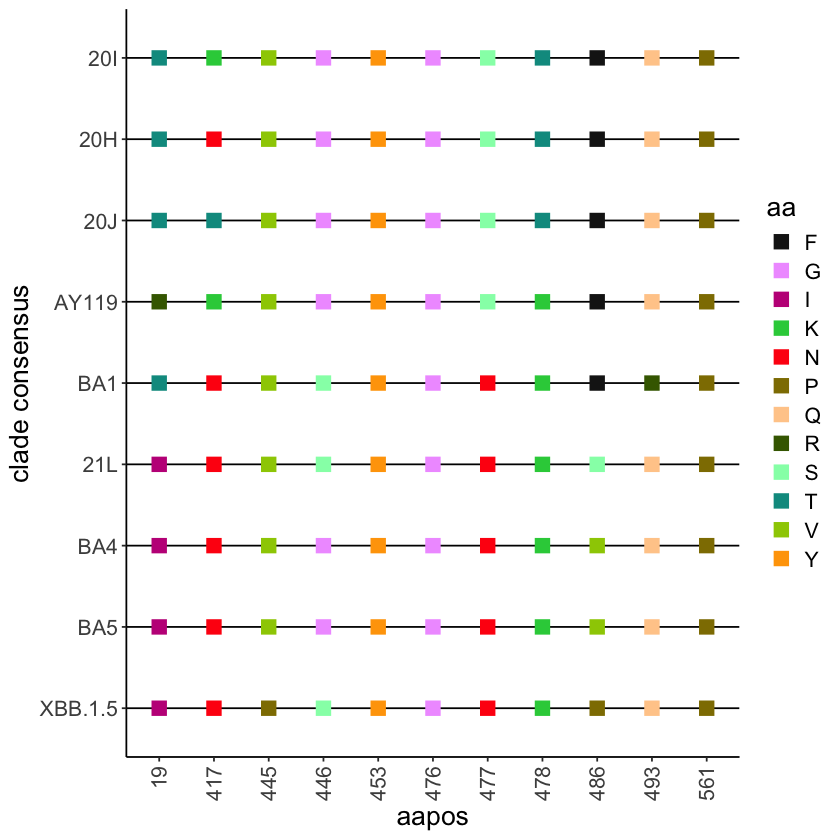

In [11]:
p2 = ggplot() + 
    geom_hline(data = refs_aadf, aes(yintercept = ref_clade)) + 
    geom_point(data = refs_aadf, 
               aes(x=factor(aapos), y=ref_clade, color = aa),
               shape = 'square', size = 4) +
    aa_colScale +
    labs(y = "clade consensus", x="aapos") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 

print(p2)

#ggsave(p2,
#       filename = glue("{FIG_DIR}/clade.consensus.spike.pdf"),
#       width = 4,
#       height = 5, limitsize=FALSE, useDingbats = FALSE)

In [12]:
dist_df = read.csv(glue("{wkdir}/20240716_covspec_dists/all_dists.csv"))
dist_df$temp = dist_df$variant

# warnings with NA
dist_df = dist_df %>% 
    mutate(date = as.Date(date, "%m/%d/%y"),
          proportion = as.numeric(as.character(proportion)),
          proportionCILow = as.numeric(as.character(proportionCILow)),
          proportionCIHigh = as.numeric(as.character(proportionCIHigh))) %>%
    separate(temp, sep = ':', c('gene_id','temp')) %>%
    separate(temp, sep = "(?<=^[A-Za-z])(?=[0-9])|(?<=[0-9])(?=[A-Za-z]$)", c('refaa','aapos','varaa')) %>%
    filter(date >= "2021-01-01" & date <= "2024-01-01")

Warning message in file(file, "rt"):
“cannot open file '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/manuscripts/202407_autopsy/GitHub_resources/20240716_covspec_dists/all_dists.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
options(repr.plot.width = 5, repr.plot.height = 8)

p0 = ggplot() + 
    geom_rect(data = dist_df, aes(xmin = as.Date("2021-11-12"), 
                  ymin = 0, 
                  xmax = as.Date("2021-12-03"), 
                  ymax = 1.0), 
             fill = 'gray', alpha = 0.01) +
    geom_line(data = dist_df, aes(x= date, y = proportion, color = varaa, group = varaa), linewidth = 1) + 
    facet_grid(factor(aapos)~.) + 
    aa_colScale

p0 

#ggsave(p0,
#       filename = glue("{FIG_DIR}/mutation.freq.voc.pdf"),
#       width = 5,
#       height = 10, limitsize=FALSE, useDingbats = FALSE)

In [ ]:
voc_df = voc_df %>% 
    dplyr::mutate(date = as.Date(date, "%m/%d/%y"),
          proportion = as.numeric(as.character(proportion)),
          proportionCILow = as.numeric(as.character(proportionCILow)),
          proportionCIHigh = as.numeric(as.character(proportionCIHigh))) %>%
    filter(date >= "2021-01-01" & date <= "2024-01-01")

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 4)

p0 = ggplot() + 
    geom_rect(data = voc_df, aes(xmin = as.Date("2021-11-12"), 
                  ymin = 0, 
                  xmax = as.Date("2021-12-03"), 
                  ymax = 1.0), 
             fill = 'gray', alpha = 0.01) +

    geom_line(data = voc_df, 
      aes(x=date, y = proportion, color = variant, group = variant), linewidth = 1) + 
    scale_color_manual(values = voc_cols) 
print(p0)

#ggsave(p0,
#       filename = glue("{FIG_DIR}/voc.freq.pdf"),
#       width = 7,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

## CliqueSNV data: 

In [13]:
# find positions that don't match
# pull out 
# build matrix
# filter for redundancies
haplotypes = seq_df %>% 
    filter(aapos %in% pull_aapos$aapos & !aapos %in% del_positions$aapos) %>% 
    ungroup() %>%
    group_by(name, number) %>%
    mutate(complete = ifelse(any(aa == "X", na.rm = TRUE), 'INCOMPLETE', 'COMPLETE')) %>%
    ungroup() %>%
    filter(complete == 'COMPLETE') %>%
    arrange(aapos) %>%
    group_by(name, freq, number) %>%
    mutate(refseq = ifelse(all(diff(aapos) >= 0), paste(refaa, collapse = ""),'false'),  # if aapos in order, concate seq
           seq = ifelse(all(diff(aapos) >= 0), paste(aa, collapse = ""),'false'),  # if aapos in order concate seq
           seq_numbering = ifelse(all(diff(aapos) >= 0), paste(aapos, collapse = ","), 'false')) %>%  # if aapos in order concat numbers
    ungroup() %>%
    select(-aapos, -aa, -refaa) %>%  # remove site specific info 
    unique() %>%
    filter(!name %in% failures) %>%
    drop_na(freq) %>% 
    group_by(name, seq) %>%
    mutate(updated_freq = sum(freq)) %>%
    ungroup()

# UNDO FOR OTHER
haplotypes = merge(haplotypes, meta, by.x = c('name'), by.y=c('pacbio_name'))

In [14]:
# pulling unique and shared haplotypes
samp_haps = haplotypes %>% 
    select(name, seq) %>% unique() %>%
    group_by(name) %>%
    tally()

unique_haps = haplotypes %>%
    select(name, seq) %>%
    unique() %>%
    group_by(seq) %>%
    tally()%>% 
    arrange(-n)

In [15]:
unique_haps = unique_haps %>% mutate(pos = row_number()) # add the consensus number
haplotypes = merge(haplotypes, unique_haps, by = 'seq', all.x = TRUE)

In [16]:
rearrange_order = haplotypes %>% 
    arrange(pos, desc(updated_freq)) %>% 
    select(name) %>% unique()

In [17]:
haplotypes %>% select(n, seq) %>% unique() %>% arrange(n)

n,seq
<int>,<chr>
1,RKAGYGNKFKS
1,RKAGYGSKFKP
1,RKVVYGSKSQP
1,RRAGFSSKFQP
1,TKAGYGNKFQP
1,TRAGFSSKFQP
2,TKAGYGNEFKP
4,TKAGYGNKFKP
5,RKVVYGSKFQP


In [18]:
haplotypes$seq = factor(haplotypes$seq, levels = unique_haps$seq) 
haplotypes$name = factor(haplotypes$name, levels = rearrange_order$name) 

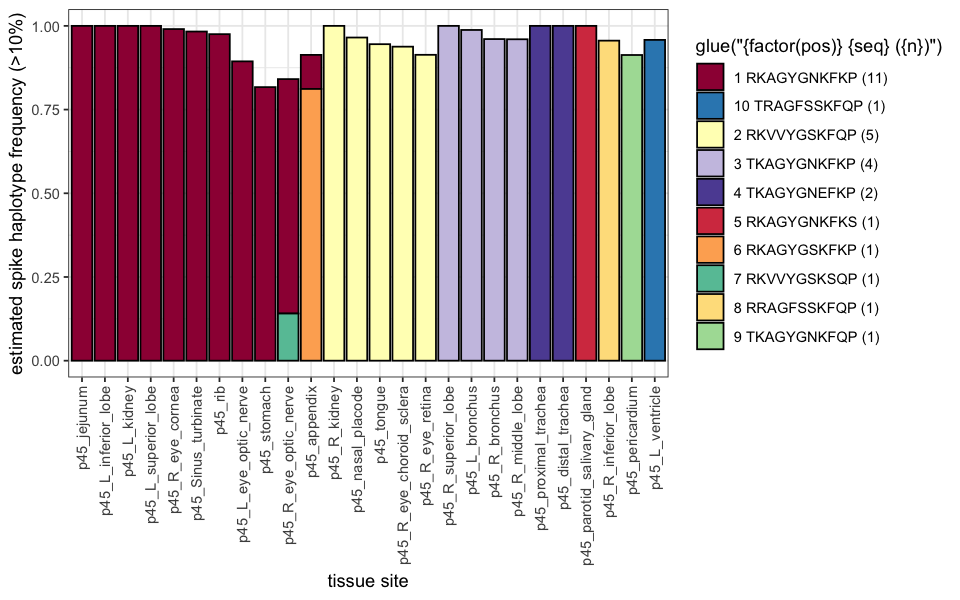

In [19]:
options(repr.plot.width = 8, repr.plot.height = 5)
p1 = haplotypes %>%
    select(name, seq, updated_freq,general_location, pos,n) %>%
    unique() %>%
    ggplot(., aes(x=name, y = updated_freq, fill = glue("{factor(pos)} {seq} ({n})"))) +
    geom_col(color = 'black') + 
    theme_bw() + 
    scale_fill_manual(values = haplotype_cols) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(y= 'estimated spike haplotype frequency (>10%)', x= "tissue site")

print(p1)

#ggsave(p1,
#       filename = glue("{FIG_DIR}/haplotype.FREQS.pdf"),
#       width = 7,
#       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [20]:
options(repr.plot.width = 7, repr.plot.height = 8)

temp_fig = seq_df %>% 
    filter(aapos %in% pull_aapos$aapos & !aapos %in% del_positions$aapos & !name %in% failures & aa != refaa) %>% 
    group_by(name, number) %>%
    mutate(complete = ifelse(any(aa == "X", na.rm = TRUE), 'INCOMPLETE', 'COMPLETE')) %>%
    ungroup() %>%
    filter(complete == 'COMPLETE') %>%
    select(name,aapos, aa, freq) %>% unique() 

temp_ref = seq_df %>% 
    filter(aapos %in% pull_aapos$aapos & !aapos %in% del_positions$aapos & name %in% c('ay119','NC_045512.2')) %>% 
    select(name,aapos, aa, freq) %>% unique() 

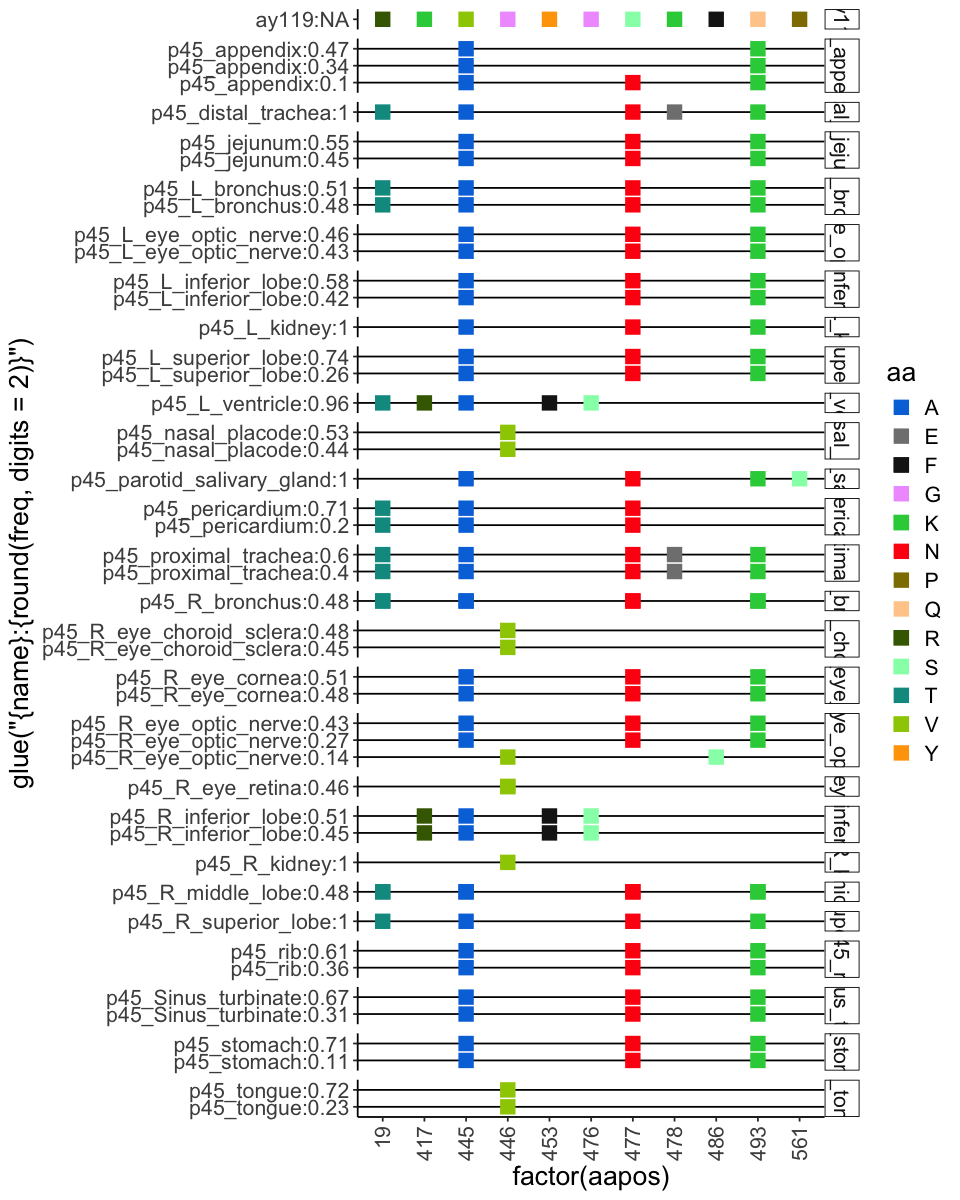

In [21]:
options(repr.plot.width = 8, repr.plot.height = 10)

p2 = ggplot() + 
    geom_hline(data = temp_fig, aes(yintercept = glue("{name}:{round(freq, digits = 2)}"))) + 
    geom_point(data = temp_fig, 
               aes(x=factor(aapos), y=glue("{name}:{round(freq, digits = 2)}"), color = aa),
               shape = 'square', size = 4) + 


    geom_point(data = temp_ref, 
               aes(x=factor(aapos), y=glue("{name}:{round(freq, digits = 2)}"), color = aa),
               shape = 'square', size = 4) +
    aa_colScale +
    facet_grid(name~., scales = 'free', space = 'free') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 

print(p2)

#ggsave(p2,
#       filename = glue("{FIG_DIR}/haplotype.sites.pdf"),
#       width = 6,
#       height = 12, limitsize=FALSE, useDingbats = FALSE)

In [22]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS 14.7.2

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/renv1/lib/libopenblas.0.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Biostrings_2.66.0   GenomeInfoDb_1.34.9 XVector_0.38.0     
 [4] IRanges_2.32.0      S4Vectors_0.36.2    BiocGenerics_0.44.0
 [7] stringi_1.8.4       glue_1.7.0          lubridate_1.9.3    
[10] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
[13] purrr_1.0.2         readr_2.1.5         tidyr_1.3.1        
[16] tibble_3.2.1        tidyverse_2.0.0     ggplot2_3.5.1      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-11          tidyselect_1.2.1       repr_1.1.7            
 [4] colorspace_2.1-1       vctrs_0.6.5            generics_0.1.3        
 [7] htmltoo